# German credit fraud

http://weka.8497.n7.nabble.com/file/n23121/credit_fruad.arff

Professor Dr. Hans Hofmann

Institut fur Statistik und Okonometrie Universitat Hamburg  
FB Wirtschaftswissenschaften  
Von-Melle-Park 5    
2000 Hamburg 13

# Exploratory data analysis
1. [Data import and summary](#Data-import-and-summary)
- [Data preparation](#Data-preparation)
- [Correlation analysis](#Correlation-analysis)
- [Feature creation and selection](#Feature-creation-and-selection)

---

## Data import and summary

In [576]:
%%html
<link rel="stylesheet" href="custom.css"/>

In [577]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from utils import plot_categorical

In [578]:
df = pd.read_csv('data/german-credit.csv')
df.head()

,over_draft,credit_usage,credit_history,purpose,current_balance,Average_Credit_Balance,employment,location,personal_status,other_parties,...,property_magnitude,cc_age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [579]:
df.shape

(1000, 21)

In [580]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
credit_usage,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
current_balance,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
location,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
cc_age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
num_dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


In [581]:
df.describe(include='O').T

,count,unique,top,freq
over_draft,1000,4,'no checking',394
credit_history,1000,5,'existing paid',530
purpose,1000,10,radio/tv,280
Average_Credit_Balance,1000,5,'<100',603
employment,1000,5,'1<=X<4',339
personal_status,1000,4,'male single',548
other_parties,1000,3,none,907
property_magnitude,1000,4,car,332
other_payment_plans,1000,3,none,814
housing,1000,3,own,713


There doesn't seem to be any obviously missing data.

In [582]:
df.isna().sum()

over_draft                0
credit_usage              0
credit_history            0
purpose                   0
current_balance           0
Average_Credit_Balance    0
employment                0
location                  0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
cc_age                    0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

### **class**
Output (categorical, binary)

In [583]:
df['class'].value_counts(normalize=True)

good    0.7
bad     0.3
Name: class, dtype: float64

As we see, the output contains no missing values and is slightly imbalanced.

Let us now split the dataset into training and test subsets so we carry all the below analysis on the training part and leave the test one for prediction.

In [584]:
# import gc
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(df, test_size=0.3, shuffle=True, stratify=df['class'])
# train.to_csv('data/train.csv', index=False)
# test.to_csv('data/test.csv', index=False)

# # Now free up the memory (is not guaranteed to work)
# del df, train, test
# gc.collect()

In [585]:
df = pd.read_csv('data/train.csv')

---

## Data preparation

This part consists of the following steps done on the feature-by-feature basis if applicable
- missing values imputation
- outlier detection and treatment
- normalization
- scaling
- factorization
- high cardinality treatment
- rare values treatment
- encoding of categoricals (since none of `sklearn`'s algorithm implementations is able to process categoricals naturally)

In [586]:
import sklearn.preprocessing as pp
from sklearn.impute import MissingIndicator
# from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

### **over_draft**
Status of existing [checking account](https://en.wikipedia.org/wiki/Transaction_account) (categorical, mixed).

Here and below we impose 5% threshold on categories to exceed.

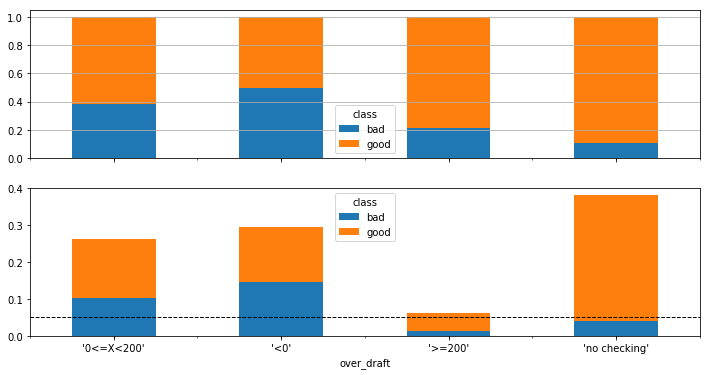

In [587]:
plot_categorical(df, 'over_draft');

`'no checking'` does not fit the ordinal nature of the feature and should be extracted.

In [588]:
(df['over_draft'] == "'no checking'").value_counts()

False    433
True     267
Name: over_draft, dtype: int64

In [589]:
over_draft_ordinal = pp.OrdinalEncoder([["'no checking'", "'<0'", "'0<=X<200'", "'>=200'"]])
over_draft_no_checking = MissingIndicator("'no checking'")

### **credit_usage**
Duration in months (categorical, cardinal), alternatively - (numeric, integer).

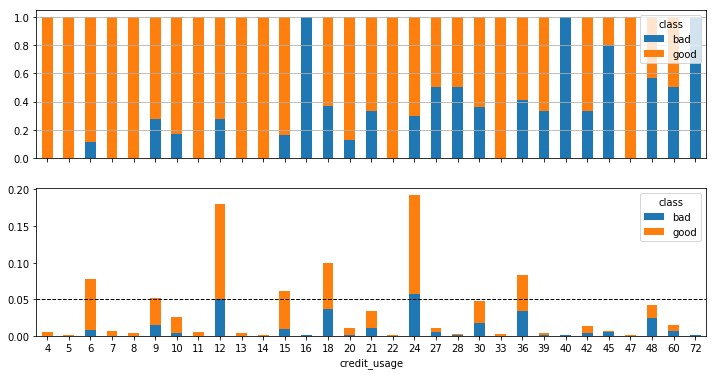

In [590]:
plot_categorical(df, 'credit_usage')

If one decides to treat the feature as categorical, one can say that it demonstrates high cardinality and the levels are better be fused (collapsed) in order to reduce the effect. E.g. low-frequency levels can be aggregated around those that rise above the 5% threshold.

If, otherwise, one decides to treat the feature as integer, nothing really needs to be done apart from simple scaling.

Being aware of the [negative effects of fusion (binning)](http://biostat.mc.vanderbilt.edu/wiki/Main/CatContinuous), we'll go the long way here to indicate that any cut points an algorithm could come up with other than those at the highly represented levels would be considered as overfitting.

In [592]:
from sklearn.base import BaseEstimator, TransformerMixin

class ThresholdBinner(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold

    def fit(self, X):
        counts = X.iloc[:,0].value_counts(normalize=True).sort_index()
        self.max_value = counts.index.max()
        self.above_threshold = counts[counts >= self.threshold].index.values
        return self

    def transform(self, X):
        def mapper(x):
            for i in self.above_threshold:
                if x <= i:
                    return i
            return self.max_value
        return X.iloc[:,0].apply(mapper).values.reshape(-1, 1)

In [593]:
credit_usage = ThresholdBinner(0.05)

Let's check out what we've achieved with the above.

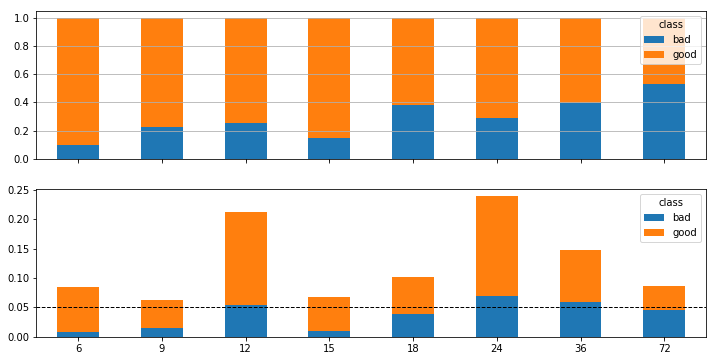

In [594]:
plot_categorical(df, credit_usage.fit_transform(df[['credit_usage']]).reshape(-1))

### **credit_history**
Credit history (categorical, nominal).

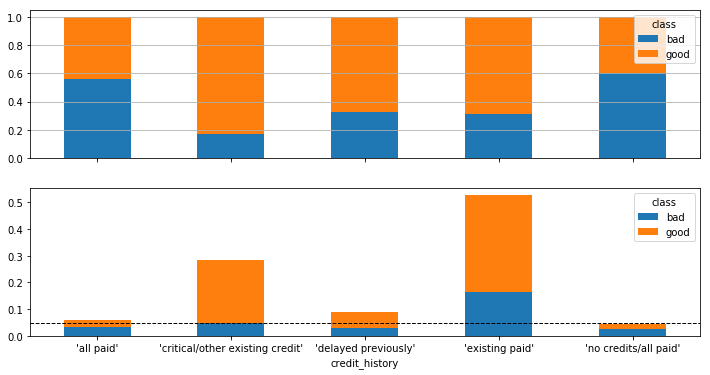

In [145]:
plot_categorical(df, 'credit_history')

In [146]:
def mapper(x):
    if x in ["'existing paid'", "'no credits/all paid'", "'all paid'"]:
        return 'paid'
    elif x == "'critical/other existing credit'":
        return 'critical'
    elif x == "'delayed previously'":
        return 'delayed'

df['credit_history'] = df['credit_history'].apply(mapper)

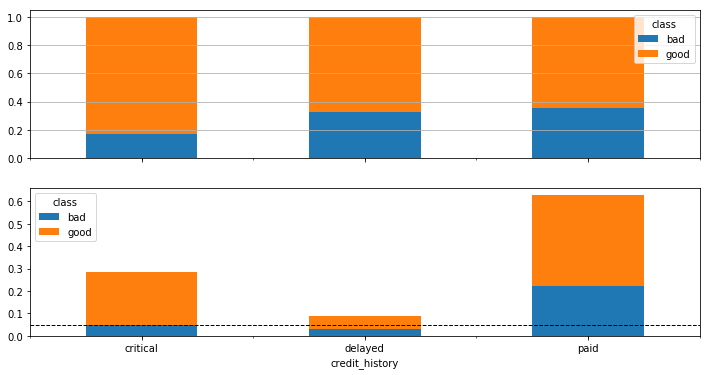

In [147]:
plot_categorical(df, 'credit_history')

In [148]:
df = pd.get_dummies(df, columns=['credit_history'], drop_first=True)

In [568]:
ct = make_column_transformer((over_draft_ordinal, ['over_draft']),
                             (over_draft_no_checking, ['over_draft']),
                             (credit_usage, ['credit_usage']),
                             remainder='passthrough')
ct.fit_transform(df)

array([[2.0, False, 18, ..., 'yes', 'yes', 'good'],
       [0.0, True, 72, ..., 'yes', 'yes', 'bad'],
       [0.0, True, 6, ..., 'none', 'yes', 'good'],
       ...,
       [2.0, False, 12, ..., 'yes', 'yes', 'bad'],
       [0.0, True, 6, ..., 'none', 'yes', 'good'],
       [0.0, True, 24, ..., 'none', 'yes', 'good']], dtype=object)

### **purpose**
Loan purpose (categorical, nominal).

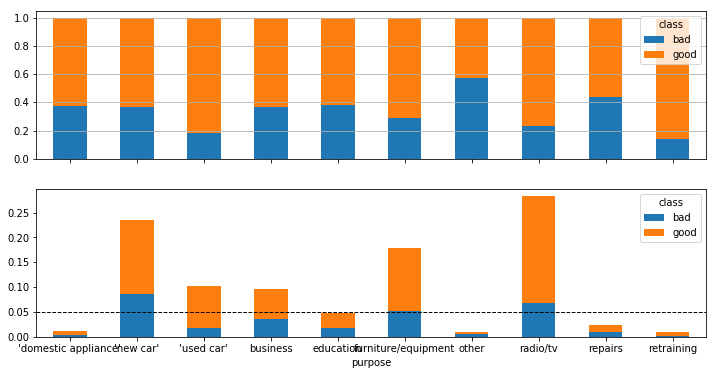

In [149]:
plot_categorical(df, 'purpose')

In [150]:
def mapper(x):
    if x == 'furniture/equipment':
        return 'furniture'
    elif x == 'retraining':
        return 'education'
    elif x in ['repairs', "'domestic appliance'"]:
        return 'other'
    elif x == "'new car'":
        return 'new_car'
    elif x == "'used car'":
        return 'used_car'
    else:
        return x

df['purpose'] = df['purpose'].apply(mapper)

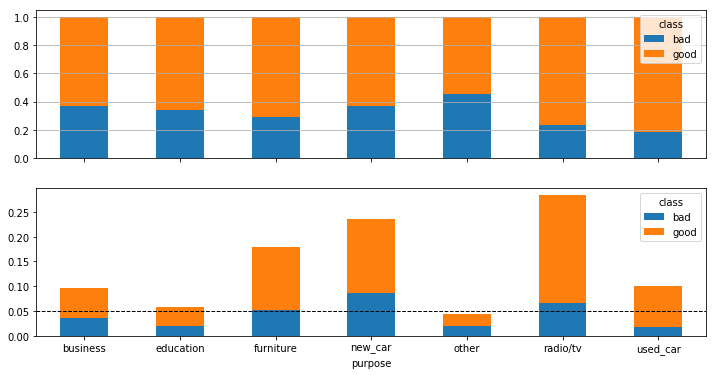

In [151]:
plot_categorical(df, 'purpose')

In [152]:
df.groupby('purpose')['class'].value_counts(normalize=True).unstack()

class,bad,good
purpose,,
business,0.367647,0.632353
education,0.341463,0.658537
furniture,0.288000,0.712000
new_car,0.369697,0.630303
other,0.451613,0.548387
radio/tv,0.236181,0.763819
used_car,0.183099,0.816901


In [153]:
df = pd.get_dummies(df, columns=['purpose'], drop_first=True)

---

### **current_balance**
Credit amount (numeric, continuous).

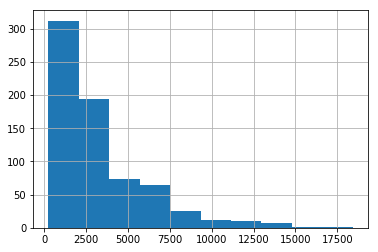

In [154]:
df['current_balance'].hist();

Clearly `current_balance` is distributed according to some power law. Let's leave it unchanged for the time being since we're going to be focusing on Random forests and Boosted trees down below that prefer continuous data.

### **Average_Credit_Balance**
Savings account/bonds (categorical, ordinal).

In [155]:
df.rename(columns={'Average_Credit_Balance': 'acb'}, inplace=True)

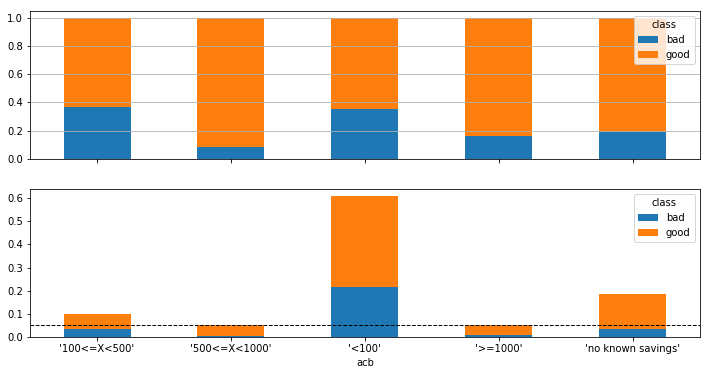

In [156]:
plot_categorical(df, 'acb')

In [157]:
mapper = {"'no known savings'": 0,
          "'<100'": 2,
          "'100<=X<500'": 4,
          "'500<=X<1000'": 8,
          "'>=1000'": 16} # preserving the log-ish scale
df['acb'] = df['acb'].map(mapper)

### **employment**
Present employment since, years (categorical, ordinal).

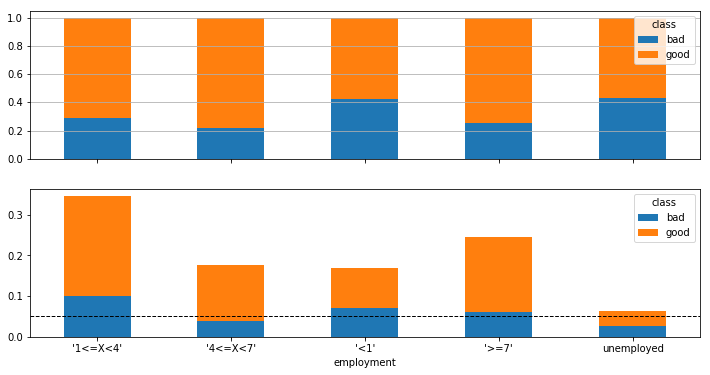

In [158]:
plot_categorical(df, 'employment')

It makes sense to squash `<1` and `unemployed` categories together, given their output odds and total counts.

In [159]:
mapper = {'unemployed': 0,
          "'<1'": 0,
          "'1<=X<4'": 1,
          "'4<=X<7'": 3,
          "'>=7'": 5}
df['employment'] = df['employment'].map(mapper)

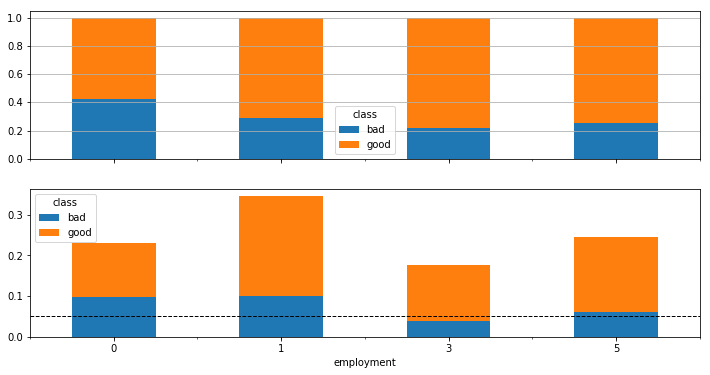

In [160]:
plot_categorical(df, 'employment')

### **location**
Installment rate in percentage of disposable income (categorical, ordinal).

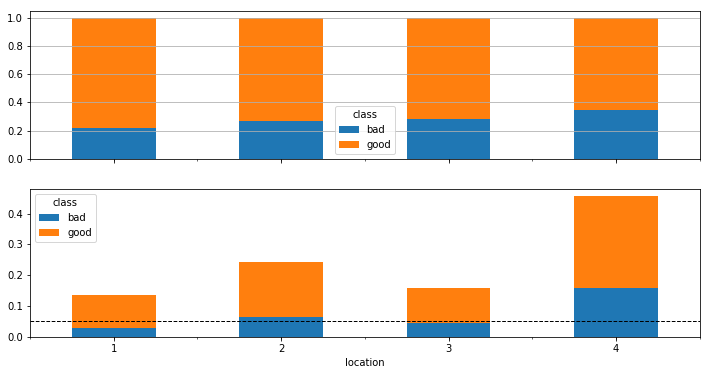

In [161]:
plot_categorical(df, 'location')

### **personal_status**
Personal status and sex (categorical, compound).

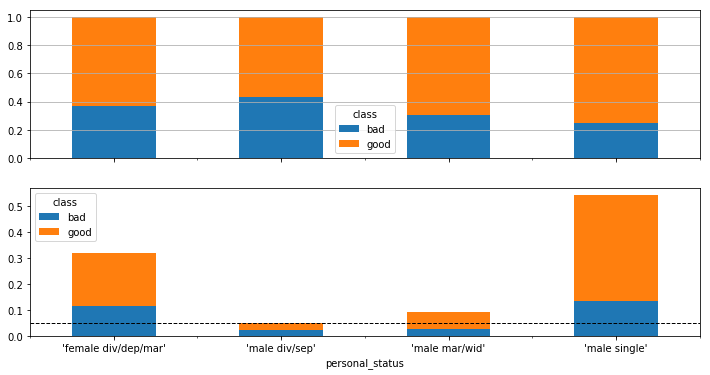

In [162]:
plot_categorical(df, 'personal_status')

Since the feature is compound let's first extract `sex` and then deal with marital status.

In [163]:
df['sex'] = (df['personal_status'] == "'female div/dep/mar'").astype(int)

In [164]:
def mapper(x):
    if x == "'male single'":
        return 0
    else:
        return 1
df['personal_status'] = df['personal_status'].apply(mapper)

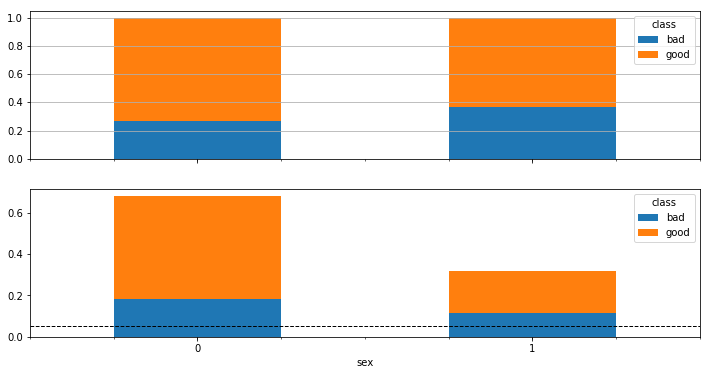

In [165]:
plot_categorical(df, 'sex')

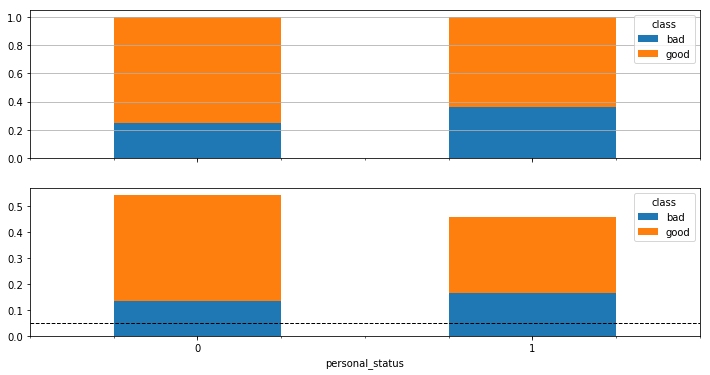

In [166]:
plot_categorical(df, 'personal_status')

### **other_parties**
Other debtors / guarantors (categorical, nominal).

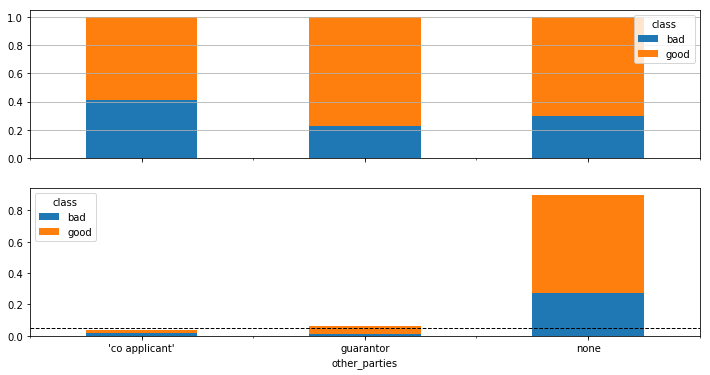

In [167]:
plot_categorical(df, 'other_parties')

In [168]:
def mapper(x):
    if x in ['guarantor', "'co applicant'"]:
        return 0
    else:
        return 1

df['other_parties'] = df['other_parties'].apply(mapper)

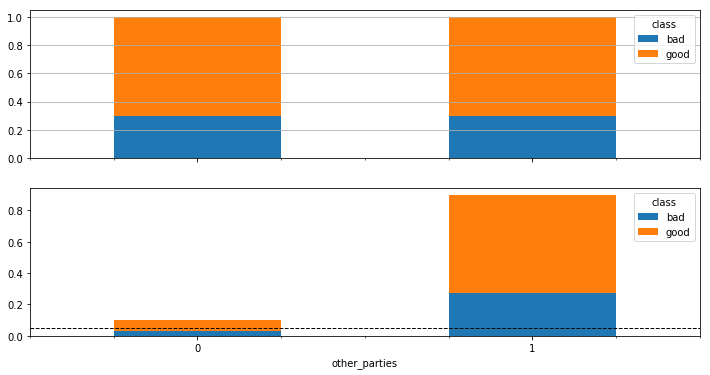

In [169]:
plot_categorical(df, 'other_parties')

As we see here, the output ratio distribution is almost uniform so no point in keeping the feature.

In [170]:
df.drop('other_parties', axis=1, inplace=True)

### **residence_since**
Present residence since (categorical, cardinal).

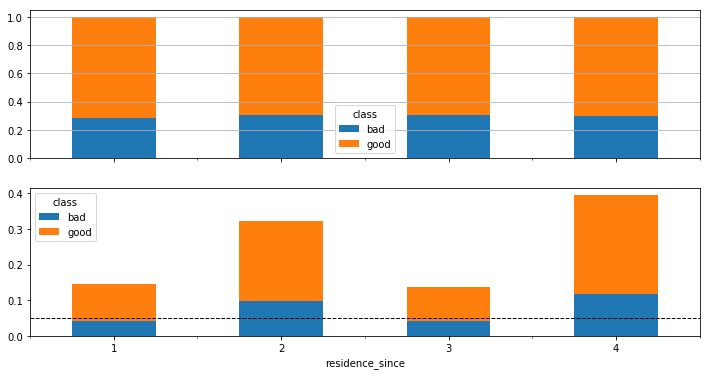

In [171]:
plot_categorical(df, 'residence_since')

Although the description provided is not very clear, the feature itself looks OK and can be left unchanged.

### **property_magnitude**
Property (categorical, nominal).

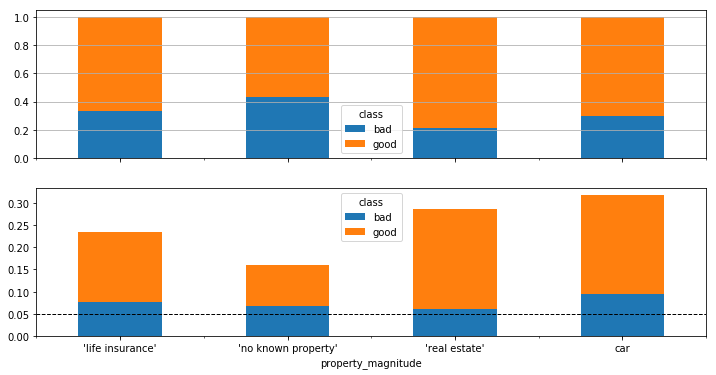

In [172]:
plot_categorical(df, 'property_magnitude')

In [173]:
# Just renaming the values
mapper = {"'life insurance'": 'life_ins',
          "'real estate'": 'real_est',
          "'no known property'": 'missing',
          'car': 'car'}
    
df['property_magnitude'] = df['property_magnitude'].map(mapper)

In [174]:
df = pd.get_dummies(df, columns=['property_magnitude'], drop_first=True)

### **cc_age**
Credit age, months (categorical, cardinal).

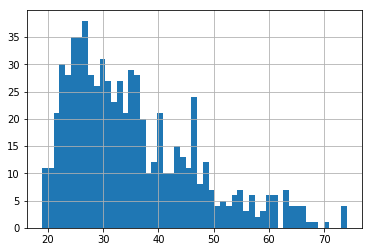

In [175]:
df['cc_age'].hist(bins=53);

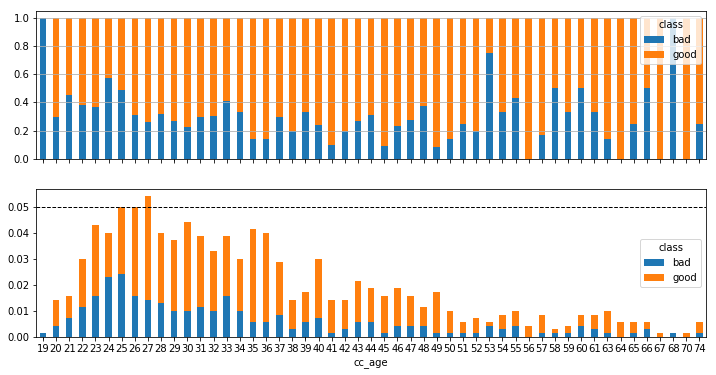

In [176]:
plot_categorical(df, 'cc_age')

Being reported as categorical the feature is inherently numeric (integer) hence it makes sense to leave it for the algorithm to bucketize if required.

### **other_payment_plans**
Other installment plans (categorical, nominal).

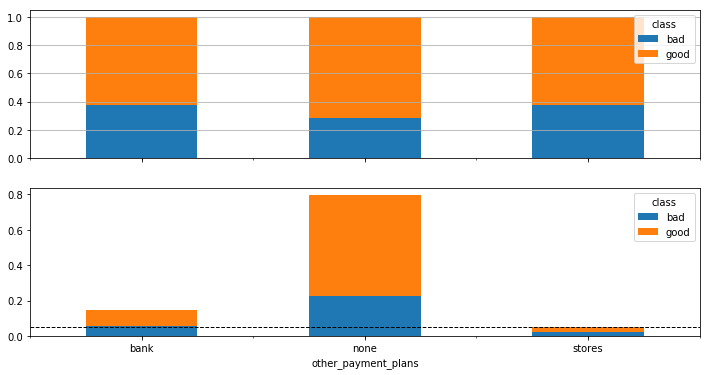

In [177]:
plot_categorical(df, 'other_payment_plans')

Since `bank` and `stores` have almost the same output odds ratio it makes sence to squash the two given `stores` being underrepresented.

In [178]:
mapper = {'bank': 'bank_stores',
          'stores': 'bank_stores',
          'none': 'none'}

df['other_payment_plans'] = df['other_payment_plans'].map(mapper)

In [179]:
df = pd.get_dummies(df, columns=['other_payment_plans'], drop_first=True)

### **housing**
Housing (categorical, nominal).

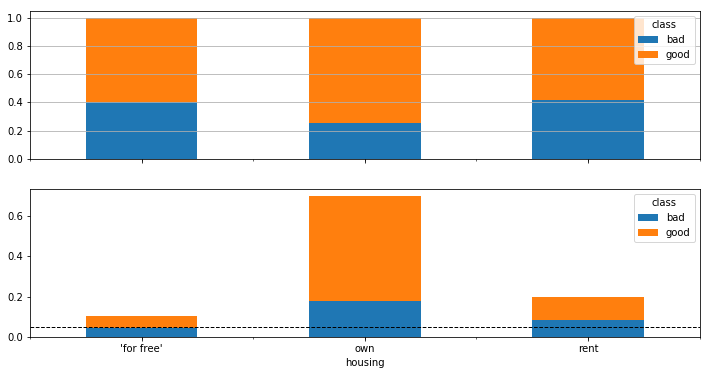

In [180]:
plot_categorical(df, 'housing')

In [181]:
def mapper(x):
    if x == "'for free'":
        return 'free'
    else:
        return x
    
df['housing'] = df['housing'].apply(mapper)

In [182]:
df = pd.get_dummies(df, columns=['housing'], drop_first=True)

### **existing_credits**
Number of existing credits at this bank (categorical, ordinal).

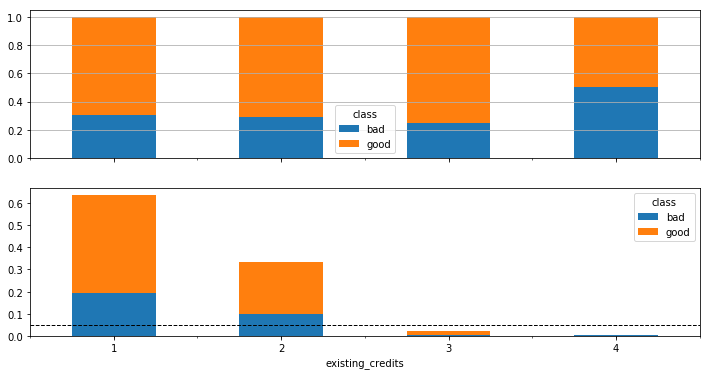

In [183]:
plot_categorical(df, 'existing_credits')

Classes `3` and `4` are heavily underrepresented. Let's try to squash `2`, `3` and `4` together.

In [184]:
def mapper(x):
    if x >= 2:
        return 2
    else:
        return x
    
df['existing_credits'] = df['existing_credits'].apply(mapper)

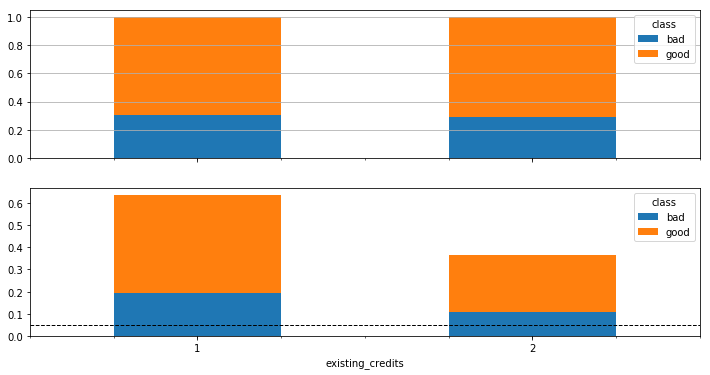

In [185]:
plot_categorical(df, 'existing_credits')

### **job**
Employment status (categorical, nominal).

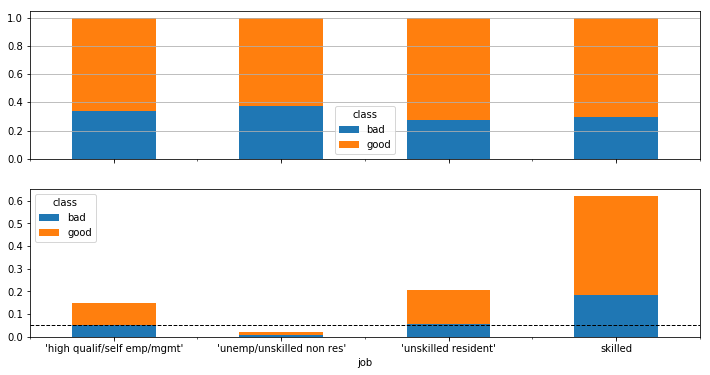

In [186]:
plot_categorical(df, 'job')

In [187]:
mapper = {'skilled': 'skilled',
          "'unskilled resident'": 'unskilled',
          "'high qualif/self emp/mgmt'": 'highly_skilled',
          "'unemp/unskilled non res'": 'unskilled'}

df['job'] = df['job'].map(mapper)

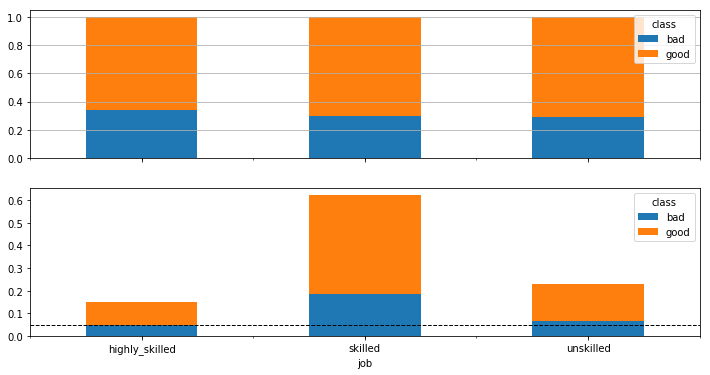

In [188]:
plot_categorical(df, 'job')

In [189]:
df = pd.get_dummies(df, columns=['job'], drop_first=True)

### **num_dependents**
Number of people being liable to provide maintenance for

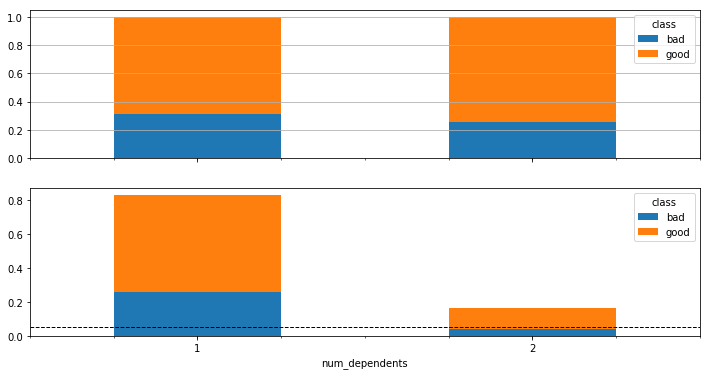

In [190]:
plot_categorical(df, 'num_dependents')

### **own_telephone**
Whether a customer has a phon registered under their name (categorical, binary).

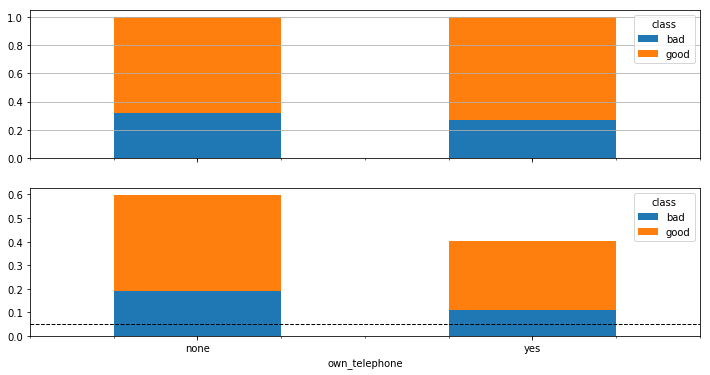

In [191]:
plot_categorical(df, 'own_telephone')

In [192]:
df = pd.get_dummies(df, columns=['own_telephone'], drop_first=True)

### **foreign_worker**
(supposedly) whether a customer came from abroad (categorical, binary).

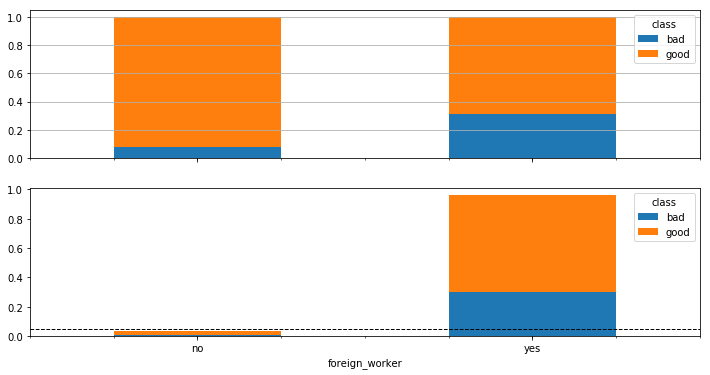

In [193]:
plot_categorical(df, 'foreign_worker')

Being heavily imbalanced the feature isn't helpful thus needs to be dropped.

In [194]:
df.drop('foreign_worker', axis=1, inplace=True)

### **class**
Let's finally encode the output.

In [195]:
mapper = {'good': 0,
          'bad': 1}

df['class'] = df['class'].map(mapper)

---

Combine all the above transformers into a pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
ct = ColumnTransformer(
    [("norm1", Normalizer(norm='l1'), [0, 1]),
     ("norm2", Normalizer(norm='l1'), slice(2, 4))])
X = np.array([[0., 1., 2., 2.],
              [1., 1., 0., 1.]])
# Normalizer scales each row of X to unit norm. A separate scaling
# is applied for the two first and two last elements of each
# row independently.
ct.fit_transform(X) 


from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
union = FeatureUnion([("pca", PCA(n_components=1)),
                      ("svd", TruncatedSVD(n_components=2))])
X = [[0., 1., 3], [2., 2., 5]]
union.fit_transform(X) 

In [196]:
df.shape

(700, 31)

In [197]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
over_draft,700.0,1.004286,0.944063,0.0,0.00,1.0,2.0,3.0
credit_usage,700.0,23.670000,17.319962,6.0,12.00,18.0,24.0,72.0
current_balance,700.0,3277.538571,2808.372793,250.0,1345.75,2321.5,4142.0,18424.0
acb,700.0,2.880000,3.554988,0.0,2.00,2.0,2.0,16.0
employment,700.0,2.100000,1.908868,0.0,1.00,1.0,3.0,5.0
location,700.0,2.940000,1.117861,1.0,2.00,3.0,4.0,4.0
personal_status,700.0,0.457143,0.498516,0.0,0.00,0.0,1.0,1.0
residence_since,700.0,2.781429,1.120468,1.0,2.00,3.0,4.0,4.0
cc_age,700.0,35.424286,11.409467,19.0,27.00,33.0,42.0,74.0
existing_credits,700.0,1.362857,0.481168,1.0,1.00,1.0,2.0,2.0


## Correlation analysis

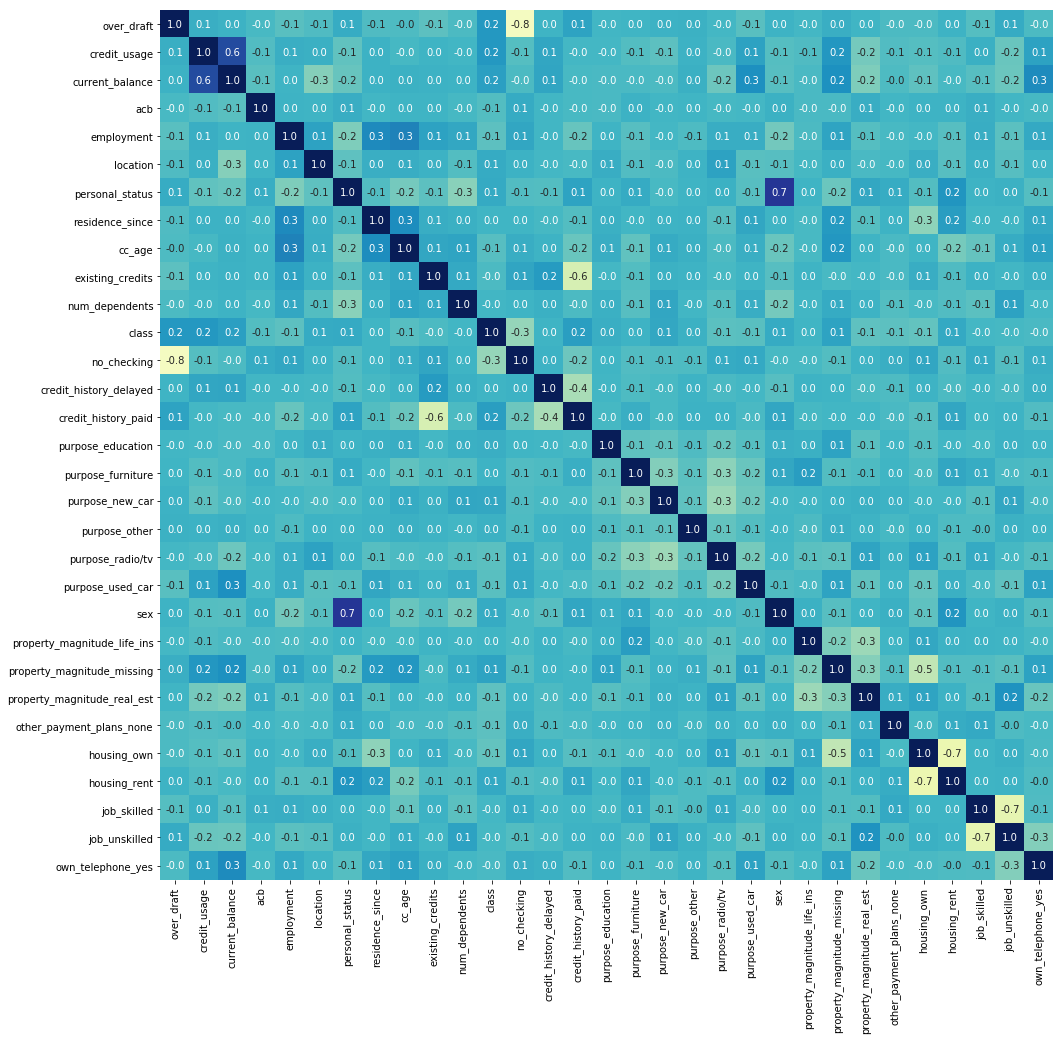

In [152]:
import seaborn as sb

plt.figure(figsize=(16, 16))
sb.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cbar=False, fmt='.1f', cmap='YlGnBu');

In [70]:
# %%time
# import warnings
# warnings.filterwarnings('ignore')

# g = sb.PairGrid(df.astype(float)['over_draft'], hue="class", hue_kws={"cmap": ["Blues", "Reds"]})
# g = g.map_diag(sb.kdeplot, lw=3)
# g = g.map_offdiag(sb.kdeplot, lw=1)

# plt.show()

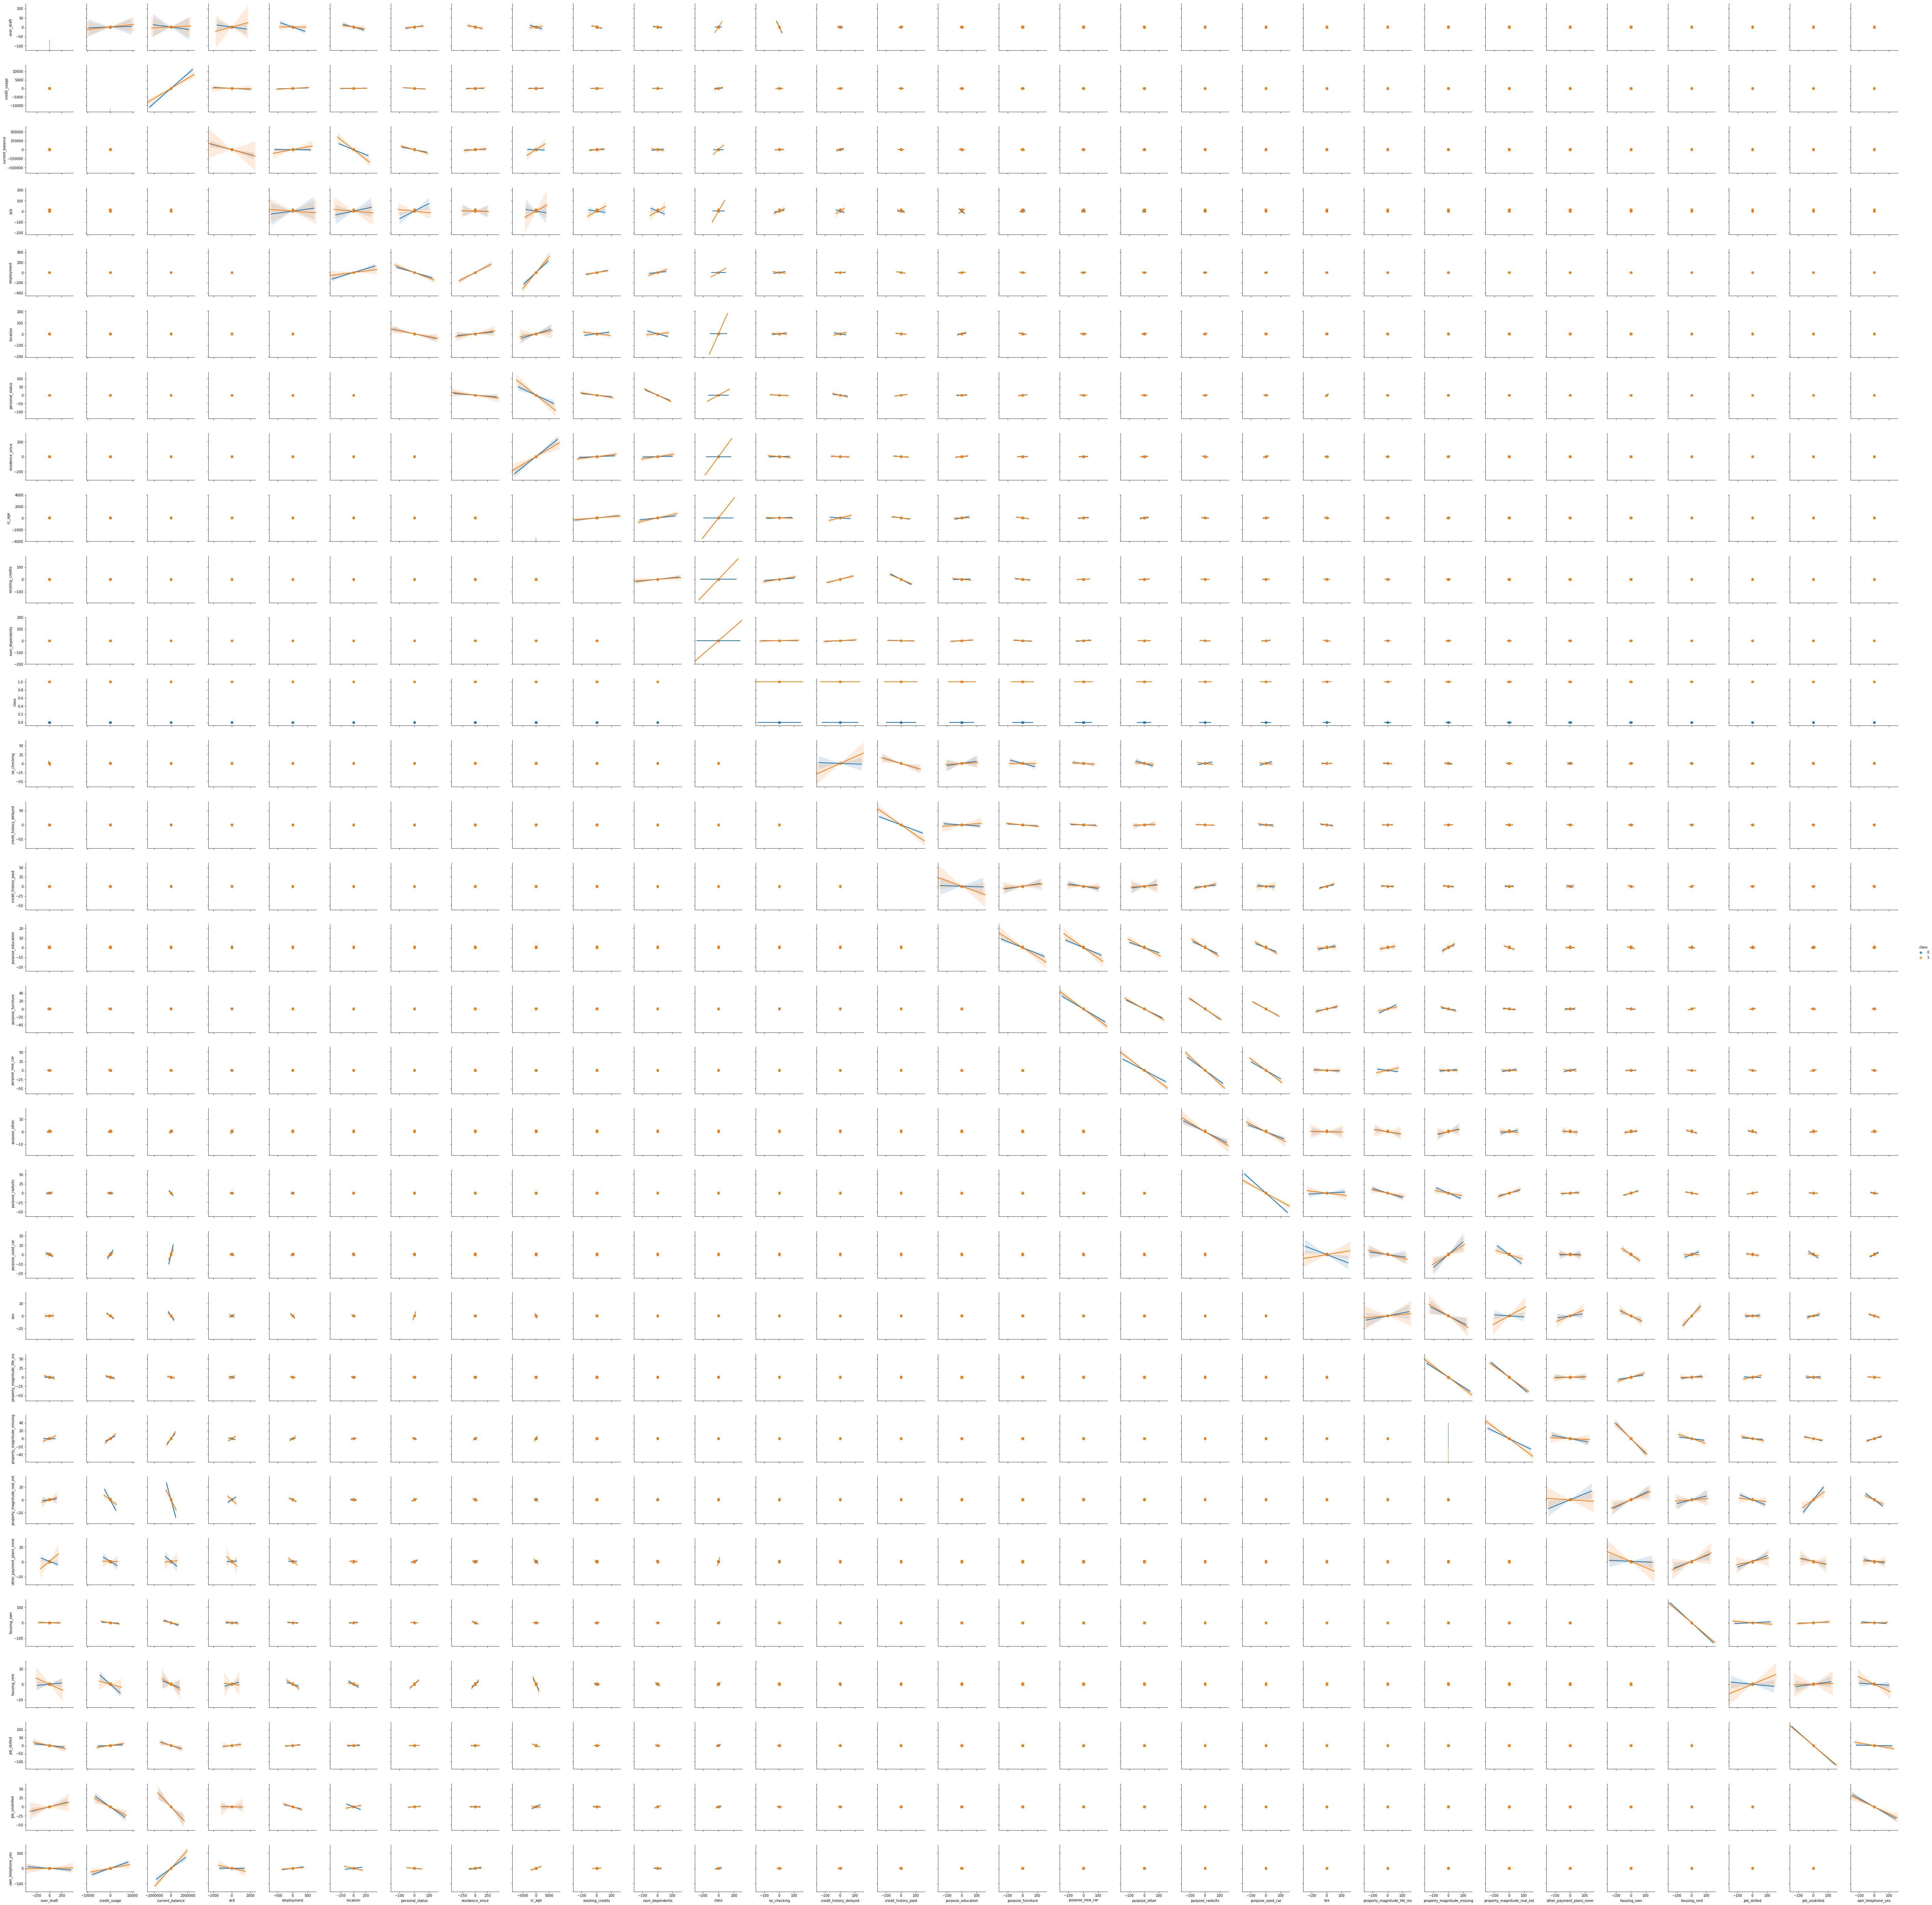

In [149]:
# Since everything is axis aligned and doesn't seem to have many
# diagonal(ish) decision boundaries tree methods should perform the best
sb.pairplot(df, hue='class', diag_kind='hist', kind='reg');

---

## Feature creation and selection

In [142]:
df.to_csv('data/german-credit-cleaned.csv', index=False)